In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy.optimize import curve_fit
from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [65]:
def gauss_func(x, a, b, c):
    d = - ((x - b) ** 2)
    return a * np.exp( d / (c ** 2) )


def log_normal_func(x, L, m, s):
    _x = x * s
    a = L / (_x * np.sqrt(2 * np.pi))
    b = - ((np.log(x) - m) ** 2)
    c = 2 * (s ** 2)
    return a * np.exp(b / c)

In [42]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
states = pd.read_csv(url,
                     usecols=['data', 'totale_casi'],
                     parse_dates=['data'],
                     index_col=['data'],
                     squeeze=True).sort_index()

In [9]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    try:
        # Find the smallest range (highest density)
        best = (highs - lows).argmin()
    except Exception as e:
        print("ERR {}".format(e))
        best = 0
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

26


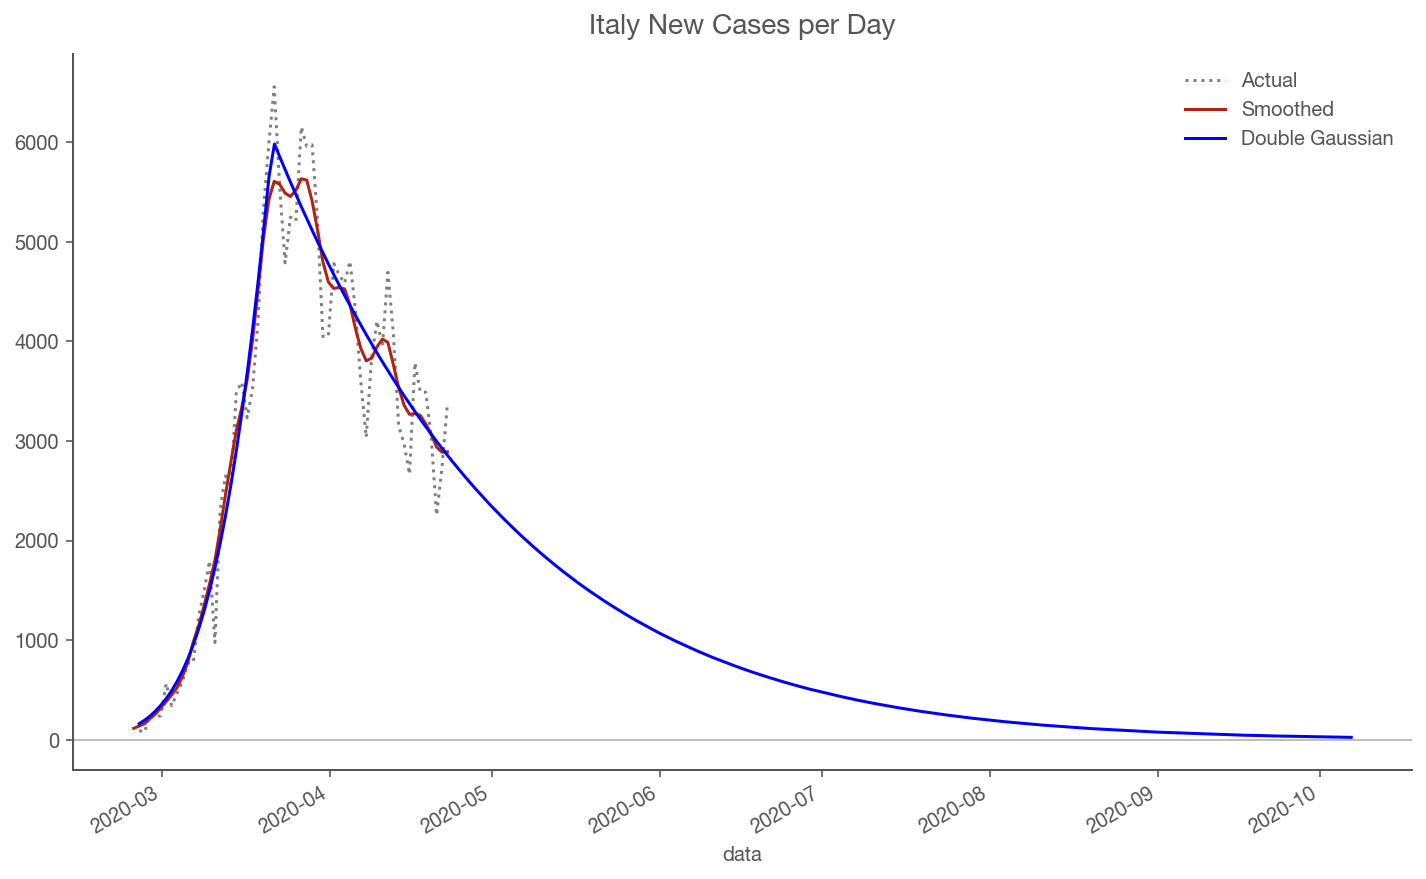

In [110]:
state_name = 'Italy'

def prepare_cases(cases, cutoff=1):
    new_cases = cases.diff()
    max_new_cases = new_cases.argmax()
    print(max_new_cases)

#    popt1, _ = curve_fit(gauss_func, [i for i in range(new_cases.size - 1)], new_cases[1:])
    popt2a, _ = curve_fit(gauss_func, [i for i in range(max_new_cases - 1)], new_cases[1:max_new_cases])
    popt2b, _ = curve_fit(
        gauss_func,
        [max_new_cases + i for i in range(new_cases.size - max_new_cases)],
        new_cases[max_new_cases:],
        p0=[new_cases[max_new_cases], max_new_cases, 1], method="dogbox"
    )
    
#    _gauss = gauss_func([i for i in range(new_cases.size)], *popt1)
    
    _asym_gauss1 = gauss_func([i for i in range(new_cases[1:max_new_cases].size)], *popt2a)
    _asym_gauss2 = gauss_func([max_new_cases + i for i in range(200)], *popt2b)
    
    _asym_gauss = np.append(_asym_gauss1, _asym_gauss2)
    
#    popt3 = np.array([2.7e5, 3.7, 0.55])
#    _log_normal = log_normal_func(np.array([i * 1. for i in range(new_cases.size)]), *popt3)
    
#    gaussian = pd.Series(
#        data=_gauss, index=new_cases.index,
#        name="Italy cases"
#    ).round()
    indexes = new_cases.index.get_level_values('data')
    asym_gaussian = pd.Series(
        data=_asym_gauss, index=pd.date_range(indexes[1], indexes[-1]+pd.Timedelta(days=168)),
        name="Italy cases"
    ).round()
#    log_normal = pd.Series(
#        data=_log_normal, index=new_cases.index,
#        name="Italy cases"
#    ).round()
    
    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=3,
        center=True).mean(std=2).round()
    idx_start = np.searchsorted(smoothed, cutoff)

    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed, asym_gaussian

cases = states.rename(f"{state_name} cases")

original, smoothed, asym_gaussian = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax = asym_gaussian.plot(label='Double Gaussian', c="b",
                   legend=True)

ax.axhline(0.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
ax.get_figure().set_facecolor('w')
ax.get_figure().set_size_inches(12, 7)

In [67]:
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

def get_posteriors(sr, sigma=0.25):

    print(sr[1:].values)
    
    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    
    print(lam)
    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    print(likelihoods)
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=1).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        # print(current_prior)
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        # print(denominator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)


[ 480.  555.  638.  731.  834.  947. 1070. 1204. 1349. 1505. 1670. 1846.
 2031. 2225. 2426. 2634. 2847. 3063. 3281. 3498. 3714. 3925. 4129. 4324.
 4509. 4681. 4837. 4976. 5096. 5196. 5274. 5330. 5361. 5369. 5353. 5313.
 5250. 5165. 5058. 4931. 4786. 4624. 4448. 4259. 4060. 3853. 3641. 3425.
 3207. 2989. 2774. 2563. 2357. 2158. 1967. 1785. 1613.]
[[  358.0205726    416.10139188   481.11723436 ...  1870.72250766
   1705.14882881  1547.37705105]
 [  358.53239606   416.69624724   481.80503587 ...  1873.3968782
   1707.58649648  1549.58916941]
 [  359.04495122   417.29195299   482.49382065 ...  1876.07507199
   1710.02764903  1551.80445019]
 ...
 [ 1982.31180629  2303.89749884  2663.88148303 ... 10357.93917185
   9441.17995877  8567.61882379]
 [ 1985.14570403  2307.19113301  2667.68974755 ... 10372.74680217
   9454.67699716  8579.86702589]
 [ 1987.98365309  2310.48947574  2671.50345633 ... 10387.57560136
   9468.19333081  8592.13273792]]
data   2020-02-25 18:00:00  2020-02-26 18:00:00  2020

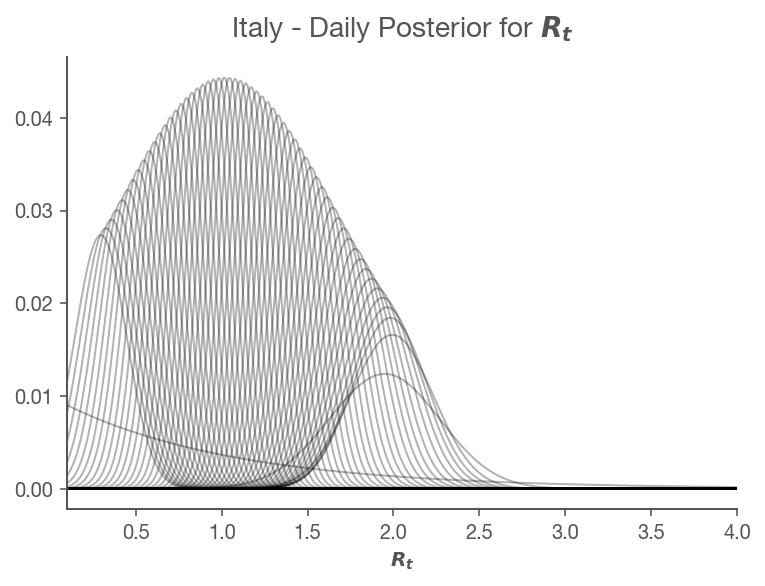

In [68]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.1,4))

ax.set_xlabel('$R_t$');

In [69]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

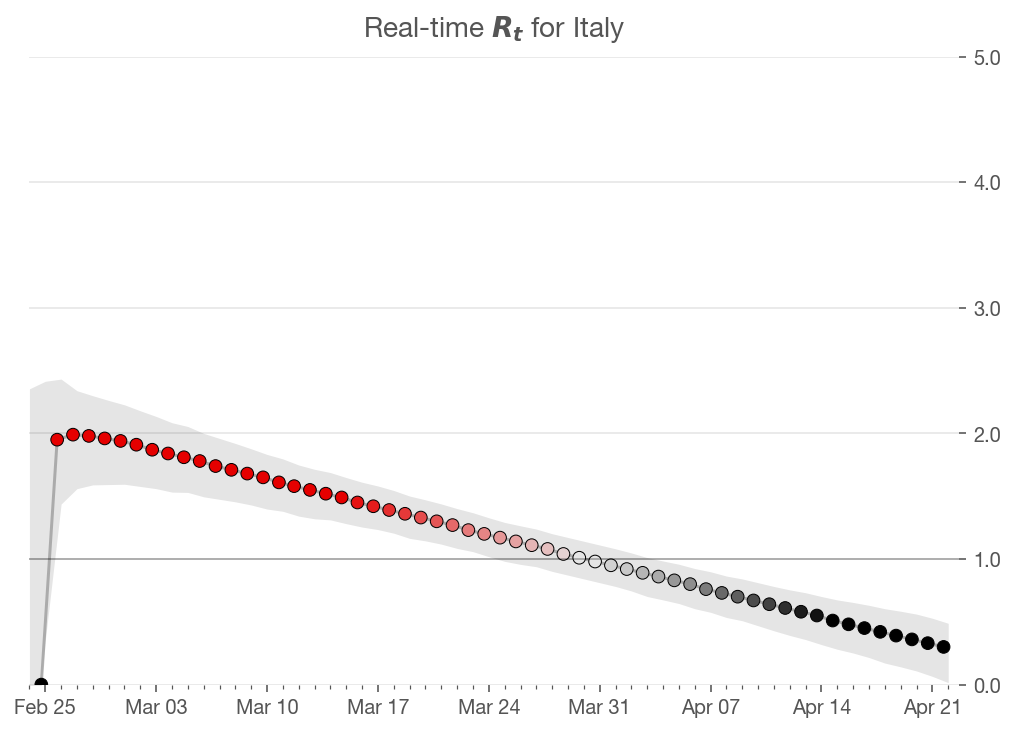

In [70]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('data')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-02-24'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-02-24'), result.index.get_level_values('data')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))